In [1]:

import os
import rasterio
import numpy as np
from skimage.io import imread
from data_generator import CustomDataGenerator
import tensorflow as tf
from UnetPP import UnetPP
from UNet import Unet
from losses.focal_tversky import FocalTverskyLoss
from losses.dice_loss import multilabel_dice_coef_loss
from keras import backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam, SGD, AdamW
import gc
import random

2023-12-01 12:14:28.280579: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 12:14:28.280637: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 12:14:28.280677: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 12:14:28.293227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
images_path = "../data/test_2/resized_800 – Kopi/"
labels_path = "../data/labels/train_v1_v4_1D – Kopi/"
all_labels = [os.path.splitext(file)[0] for file in os.listdir(labels_path) if file.endswith(".npy")]
n_classes = 4
image_size = (300, 800)
batch_size = 8
train_test_split = 0.8
random.shuffle(all_labels)
train_image_ids = all_labels[:int(len(all_labels)*train_test_split)]
val_image_ids = all_labels[int(len(all_labels)*train_test_split):]
from_logits=False
train_data_generator = CustomDataGenerator(images_path, labels_path, train_image_ids, image_size=image_size, batch_size=batch_size, n_classes=n_classes, logits=from_logits, transform=True)
val_data_generator = CustomDataGenerator(images_path, labels_path, val_image_ids, image_size=image_size, batch_size=batch_size, n_classes=n_classes, logits=from_logits, transform=True)

In [3]:
K.clear_session()
gc.collect()
h, w = image_size
gpu_device = "/device:GPU:0"

with tf.device(gpu_device):
    input_img = Input((h, w, 4), name='img')
    # model = UnetPP((h, w, 4), n_classes, using_deep_supervision=True)
    model = Unet(4, input_img, n_filters=64)
    metrics = [tf.keras.metrics.IoU(num_classes=4, target_class_ids = [0,1,2,3]),
     tf.keras.metrics.MeanIoU(n_classes,ignore_class=[0]),
               "accuracy"]#type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0005
    model.compile(optimizer=Adam(learning_rate=0.001, weight_decay=0.00005), loss="categorical_crossentropy", metrics=metrics)

2023-12-01 12:14:32.173276: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB, pci bus id: 0000:b7:00.0, compute capability: 7.0


In [4]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=5, 
    verbose=1,
    restore_best_weights=True
)
results = model.fit(train_data_generator,
                    validation_data=val_data_generator,
                    epochs=100,
                    verbose=1,
                    callbacks=[early_stopping],
                    class_weight={0:0.05, 1:0.2, 2:0.45, 3:0.30},
                    validation_freq=1
                   )


Epoch 1/100


2023-12-01 12:14:42.387514: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-01 12:14:43.715889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-01 12:14:50.266720: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3daa044c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-01 12:14:50.266764: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM3-32GB, Compute Capability 7.0
2023-12-01 12:14:50.274723: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-01 12:14:50.422041: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled clu

37/37 [==============================] - 67s 1s/step - loss: 0.0499 - io_u: 0.3750 - mean_io_u: 2.5685e-07 - accuracy: 0.8502 - val_loss: 32563.3652 - val_io_u: 0.2567 - val_mean_io_u: 0.0075 - val_accuracy: 0.0151
Epoch 2/100
37/37 [==============================] - 29s 787ms/step - loss: 0.0318 - io_u: 0.3750 - mean_io_u: 0.0000e+00 - accuracy: 0.9208 - val_loss: 249.9885 - val_io_u: 0.3045 - val_mean_io_u: 0.0223 - val_accuracy: 0.0631
Epoch 3/100
37/37 [==============================] - 30s 794ms/step - loss: 0.0276 - io_u: 0.3750 - mean_io_u: 0.0000e+00 - accuracy: 0.9283 - val_loss: 48.9034 - val_io_u: 0.3329 - val_mean_io_u: 0.0215 - val_accuracy: 0.0913
Epoch 4/100
37/37 [==============================] - 30s 798ms/step - loss: 0.0251 - io_u: 0.3750 - mean_io_u: 0.0000e+00 - accuracy: 0.9353 - val_loss: 30.1182 - val_io_u: 0.3195 - val_mean_io_u: 0.0193 - val_accuracy: 0.0798
Epoch 5/100
37/37 [==============================] - 29s 792ms/step - loss: 0.0242 - io_u: 0.3750 - mea

In [5]:
import matplotlib.pyplot as plt
class_colors = {
    0: [0, 0, 0],     # Class 0:  black: background
    1: [0, 255, 0],     # Class 1: Green: Strandberg
    2: [0, 0, 255],     # Class 2: Blue: strand
    3: [255, 0, 0]   # Class 3: red: Menneskapt struktur
}

In [6]:
from losses.iou import calculate_iou

val_data_generator = CustomDataGenerator(images_path, labels_path, val_image_ids, image_size=image_size,n_classes=4, batch_size=1, logits=True, transform=True)
save_dir = "./results/test/"
image_id = 0
sum_iou = [0,0,0,0]
class_c = [0,0,0,0]
for x_val, y_val in val_data_generator:
    test = model.predict(x_val)
    test = np.squeeze(test[-1])
    res = np.argmax(test, axis=-1)
    iou = calculate_iou(y_val, res, 4)
    print("iou all: ", iou)
    for i in range(0,4):
        if np.sum(np.where(y_val==i,1,0)) > 0:
            sum_iou[i] += iou[i]
            class_c[i] += 1
    copy = np.zeros((res.shape[0], res.shape[1], 3), dtype=np.uint8)
    for class_idx in range(4):
        color = class_colors.get(class_idx, [0, 0, 0])
        mask = (res == class_idx)
        copy[mask] = color
    res = copy
   
    y_val = np.squeeze(y_val)
    
    copy = np.zeros((y_val.shape[0], y_val.shape[1], 3), dtype=np.uint8)
    for class_idx in range(4):
        color = class_colors.get(class_idx, [0, 0, 0])
        mask = (y_val == class_idx)
    
        copy[mask] = color

    # print("input: ")
    # plt.imshow(np.squeeze(x_val))
    # plt.axis('off')
    # plt.show()
    
    # print("label: ")
    # plt.imshow(copy)
    # plt.axis('off')
    # plt.show()

    # print("pred: ")
    # plt.imshow(np.squeeze(res))
    # plt.axis('off')
    # plt.show()

    # np.save(save_dir + f"input_{image_id}", np.squeeze(x_val))
    # np.save(save_dir + f"label_{image_id}", np.squeeze(copy))
    # np.save(save_dir + f"pred_{image_id}", np.squeeze(res))
    # image_id += 1
    



1/1 [==============================] - 2s 2s/step
iou all:  [0.8941794953929642, 0.5502092050209205, 0.0, 0.4051420029895366]
1/1 [==============================] - 0s 26ms/step
iou all:  [0.9837880954300334, 0.12751470133085732, 0.10933333333333334, 0.2197189382110194]
1/1 [==============================] - 0s 26ms/step
iou all:  [0.9614862526948976, 0.6436629690818976, 0.16267387944358577, 0]
1/1 [==============================] - 0s 30ms/step
iou all:  [0.9806223389607914, 0.4637120412709579, 0, 0]
1/1 [==============================] - 0s 26ms/step
iou all:  [0.9530337068772229, 0.5399621049005253, 0, 0]
1/1 [==============================] - 0s 26ms/step
iou all:  [0.9511104103788459, 0.565187613130473, 0.37173082574199234, 0.0]
1/1 [==============================] - 0s 24ms/step
iou all:  [0.9800081116706661, 0.06670387943064471, 0.18313689936536717, 0.33412067854842176]
1/1 [==============================] - 0s 25ms/step
iou all:  [0.9946182038518344, 0.25105263157894736, 0.1073

In [7]:
print(sum_iou)
print(class_c)
for i in range(len(sum_iou)):
    print(sum_iou[i]/class_c[i])

[71.0200345107911, 28.18399216574538, 4.42977436376934, 9.934873772210514]
[74, 70, 38, 43]
0.9597301960917717
0.4026284595106483
0.11657300957287738
0.23104357609791892


In [8]:
history = results
print(history.history.keys())

dict_keys(['loss', 'io_u', 'mean_io_u', 'accuracy', 'val_loss', 'val_io_u', 'val_mean_io_u', 'val_accuracy'])


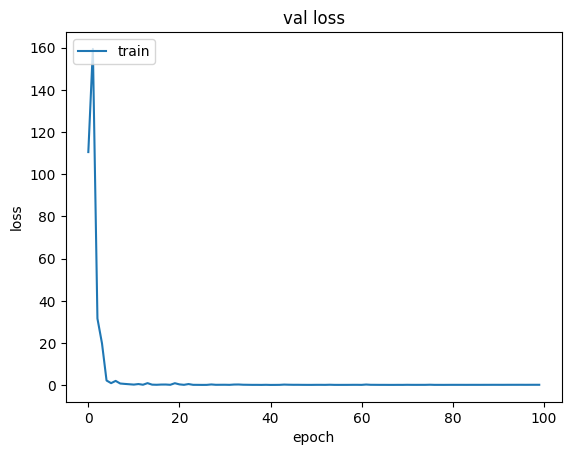

In [12]:
# summarize history for accuracy
# plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

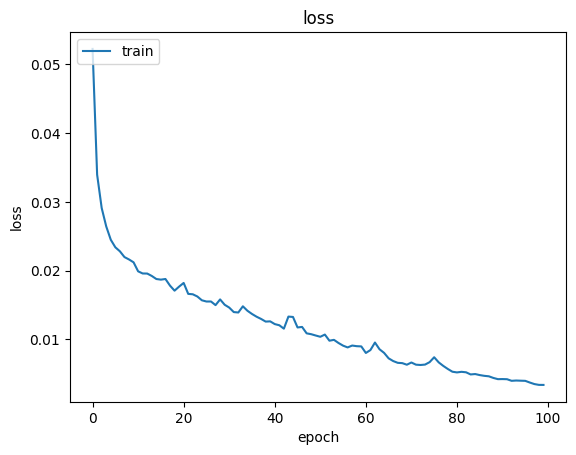

In [10]:
# summarize history for accuracy
# plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()